In [1]:
import pandas as pd
import numpy as np
import word2vec
from tqdm.notebook import tqdm
import pickle
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16 , preprocess_input
from tensorflow.keras.preprocessing.image import load_img , img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input , Dense , LSTM , Embedding , Dropout , add

In [2]:
df=pd.read_csv("train.csv")

In [3]:
df.head(10)

,filename,captions,image
0,rsicd_images/airport_1.jpg,['Many aircraft are parked next to a long buil...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
1,rsicd_images/airport_10.jpg,['some planes are parked in an airport.'\n 'th...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
2,rsicd_images/airport_100.jpg,['Many aircraft are parked in an airport near ...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
3,rsicd_images/airport_101.jpg,['Many aircraft are parked near a large buildi...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
4,rsicd_images/airport_102.jpg,['several buildings and green trees are around...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
5,rsicd_images/airport_103.jpg,['Some green trees are near a large piece of b...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
6,rsicd_images/airport_104.jpg,['Many aircraft are parked between several bui...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
7,rsicd_images/airport_105.jpg,['Many aircraft and buildings are located in a...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
8,rsicd_images/airport_106.jpg,['is a airport in the middle and many planes i...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
9,rsicd_images/airport_107.jpg,['Many aircraft are parked near several buildi...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...


In [4]:
df=df.drop('image',axis=1)

In [5]:
df['filename']=df['filename'].str[13:]

In [6]:
df['filename']='images/'+df['filename']

In [7]:
def draw(img,title='fox'):
    plt.imshow(img,cmap='gray')
    plt.axis('off')
    plt.show()

(224, 224, 3)


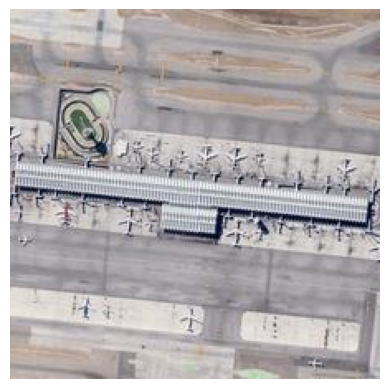

array([[[221, 214, 204],
        [216, 209, 199],
        [213, 206, 196],
        ...,
        [169, 146, 130],
        [167, 144, 130],
        [164, 141, 127]],

       [[227, 220, 210],
        [224, 217, 207],
        [221, 214, 204],
        ...,
        [169, 146, 130],
        [167, 144, 130],
        [165, 142, 128]],

       [[219, 215, 206],
        [219, 215, 206],
        [218, 214, 205],
        ...,
        [160, 138, 124],
        [158, 136, 123],
        [156, 134, 121]],

       ...,

       [[188, 177, 173],
        [187, 176, 172],
        [186, 175, 171],
        ...,
        [195, 196, 200],
        [199, 203, 206],
        [191, 195, 198]],

       [[191, 178, 172],
        [192, 179, 173],
        [193, 180, 174],
        ...,
        [169, 170, 174],
        [180, 184, 187],
        [178, 182, 185]],

       [[189, 176, 170],
        [193, 180, 174],
        [196, 183, 177],
        ...,
        [166, 167, 171],
        [177, 181, 184],
        [178, 182, 185]]

In [8]:
img=cv2.imread(df['filename'][0])
print(img.shape)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
draw(img)
np.asarray(img)

In [9]:
image=img.reshape((1,img.shape[0],img.shape[1],img.shape[2]))

In [12]:
image

array([[[[221, 214, 204],
         [216, 209, 199],
         [213, 206, 196],
         ...,
         [169, 146, 130],
         [167, 144, 130],
         [164, 141, 127]],

        [[227, 220, 210],
         [224, 217, 207],
         [221, 214, 204],
         ...,
         [169, 146, 130],
         [167, 144, 130],
         [165, 142, 128]],

        [[219, 215, 206],
         [219, 215, 206],
         [218, 214, 205],
         ...,
         [160, 138, 124],
         [158, 136, 123],
         [156, 134, 121]],

        ...,

        [[188, 177, 173],
         [187, 176, 172],
         [186, 175, 171],
         ...,
         [195, 196, 200],
         [199, 203, 206],
         [191, 195, 198]],

        [[191, 178, 172],
         [192, 179, 173],
         [193, 180, 174],
         ...,
         [169, 170, 174],
         [180, 184, 187],
         [178, 182, 185]],

        [[189, 176, 170],
         [193, 180, 174],
         [196, 183, 177],
         ...,
         [166, 167, 171],
        

In [7]:
mapping={}
for index,row in df.iterrows():
    if row['filename'] not in mapping:
        mapping[row['filename']]=[]
    a=row['captions'].split('\n')
    for capt in a:
        mapping[row['filename']].append(capt)

In [8]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
C:\Users\bhavini r. botre\AppData\Local\Temp\ipykernel_3688\822461702.py:12: SyntaxWarning: invalid escape sequence '\s'
  caption = caption.replace('\s+', ' ')


In [9]:
mapping['images/airport_1.jpg']

["['Many aircraft are parked next to a long building in an airport.'",
 " 'Many planes are parked next to a long building at an airport.'",
 " 'Many planes are parked next to a long building in an airport.'",
 " 'many planes are parked next to a long building at an airport.'",
 " 'many planes are parked next to a long building in an airport .']"]

In [9]:
clean(mapping)

In [11]:
mapping['images/airport_1.jpg']

["startseq ['many aircraft are parked next to long building in an airport.' endseq",
 "startseq 'many planes are parked next to long building at an airport.' endseq",
 "startseq 'many planes are parked next to long building in an airport.' endseq",
 "startseq 'many planes are parked next to long building at an airport.' endseq",
 "startseq 'many planes are parked next to long building in an airport .'] endseq"]

In [10]:
model = VGG16()
model = Model(inputs = model.inputs , outputs = model.layers[-2].output)
print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
features = {}
i=1
for img_path in df['filename']:
    image=load_img(img_path, target_size=(224, 224))
    image=img_to_array(image)
    image=image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image=preprocess_input(image)
    feature=model.predict(image, verbose=0)
    features[img_path]=feature
    print("done ",i)
    i+=1

done  1
done  2
done  3
done  4
done  5
done  6
done  7
done  8
done  9
done  10
done  11
done  12
done  13
done  14
done  15
done  16
done  17
done  18
done  19
done  20
done  21
done  22
done  23
done  24
done  25
done  26
done  27
done  28
done  29
done  30
done  31
done  32
done  33
done  34
done  35
done  36
done  37
done  38
done  39
done  40
done  41
done  42
done  43
done  44
done  45
done  46
done  47
done  48
done  49
done  50
done  51
done  52
done  53
done  54
done  55
done  56
done  57
done  58
done  59
done  60
done  61
done  62
done  63
done  64
done  65
done  66
done  67
done  68
done  69
done  70
done  71
done  72
done  73
done  74
done  75
done  76
done  77
done  78
done  79
done  80
done  81
done  82
done  83
done  84
done  85
done  86
done  87
done  88
done  89
done  90
done  91
done  92
done  93
done  94
done  95
done  96
done  97
done  98
done  99
done  100
done  101
done  102
done  103
done  104
done  105
done  106
done  107
done  108
done  109
done  110
done  11

In [14]:
pickle.dump(features, open(os.path.join("D:/image captioning", 'featured.pkl'), 'wb'))

In [10]:
with open(os.path.join("D:/image captioning", 'featured.pkl'), 'rb') as f:
    features = pickle.load(f)

In [ ]:
all_captions = []
for id in mapping:
    for caption in mapping[id]:
        all_captions.append(caption)

In [12]:
len(all_captions)

42548

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

In [ ]:
ids=list(mapping.keys())

In [ ]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = [], [], []
    n = 0
    while True:
        for key in data_keys:
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
                # Check if we have reached the batch size
                if len(X1) == batch_size:
                    # Convert lists to NumPy arrays
                    X1 = np.array(X1)
                    X2 = np.array(X2)
                    y = np.array(y)
                    # Yield the batch
                    yield [X1, X2], y
                    # Reset the batch data
                    X1, X2, y = [], [], []


In [ ]:
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')



In [ ]:
epochs = 10
batch_size = 32
steps = len(ids) // batch_size
generator = data_generator(ids, mapping, features, tokenizer, max_length, vocab_size, batch_size)
model.fit(generator, epochs=10, steps_per_epoch=steps, verbose=1)

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
    return in_text